In [1]:
import urllib
import zipfile
import os
import time
from pathlib import Path

from tqdm import tqdm
import skimage
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.random_projection import GaussianRandomProjection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

In [3]:
plt.rcParams['figure.figsize'] = (12, 10)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

sns.set()

In [4]:
DATASET_NAME = 'val2017'
RESIZED_IMG_FOLDER = 'img64'
RESIZED_DIM = 64

In [5]:
def download_coco_dataset(dataset_name, *, force_download=False):
    """
    Downloads a COCO dataset into the working directory.
    """
    url = f'http://images.cocodataset.org/zips/{dataset_name}.zip'
    zip_name = f'{dataset_name}.zip'
    
    download = force_download or (not os.path.isdir(dataset_name))
    if not download:
        return
    
    urllib.request.urlretrieve(URL, zip_name)
    
    if not os.path.isdir(dataset_name):
        os.mkdir(dataset_name)
    
    with zipfile.ZipFile(zip_name, 'r') as zip_file:
        zip_file.extractall('./')
    
    os.remove(zip_name)

In [6]:
download_coco_dataset(DATASET_NAME)

In [7]:
# Resizes images to lower dimensions

if not os.path.isdir(RESIZED_IMG_FOLDER):
    os.mkdir(RESIZED_IMG_FOLDER)

for filename in os.listdir(DATASET_NAME):
    input_filepath = Path(DATASET_NAME) / filename
    im = skimage.io.imread(input_filepath)
    im = skimage.transform.resize(im, output_shape=(RESIZED_DIM, RESIZED_DIM))
    im = (im * 255).astype(np.uint8)
    output_filepath = Path(RESIZED_IMG_FOLDER) / filename
    skimage.io.imsave(output_filepath, im)

/tmp/ipykernel_6975/3012897223.py:12: UserWarning: /home/seljuk/Desktop/workspace/pca-vs-random-projection-comparison-on-kmeans/img64/000000214205.jpg is a low contrast image
  skimage.io.imsave(output_filepath, im)
/tmp/ipykernel_6975/3012897223.py:12: UserWarning: /home/seljuk/Desktop/workspace/pca-vs-random-projection-comparison-on-kmeans/img64/000000379453.jpg is a low contrast image
  skimage.io.imsave(output_filepath, im)
/tmp/ipykernel_6975/3012897223.py:12: UserWarning: /home/seljuk/Desktop/workspace/pca-vs-random-projection-comparison-on-kmeans/img64/000000496409.jpg is a low contrast image
  skimage.io.imsave(output_filepath, im)
/tmp/ipykernel_6975/3012897223.py:12: UserWarning: /home/seljuk/Desktop/workspace/pca-vs-random-projection-comparison-on-kmeans/img64/000000135673.jpg is a low contrast image
  skimage.io.imsave(output_filepath, im)


In [8]:
class RandomColumnSampler(BaseEstimator, TransformerMixin):
    def __init__(self, n_component):
        self._selected_indices = None
        self.n_component = n_component

    def fit(self, X=None, y=None):
        
        n_total_component = X.shape[1]
        self._selected_indices = np.random.choice(np.arange(n_total_component), self.n_component, replace=False)
        
        return self

    def transform(self, X=None):
        return  X[:, self._selected_indices]

In [9]:
class HighVarianceSampler(BaseEstimator, TransformerMixin):
    def __init__(self, n_component):
        self._selected_indices = None
        self.n_component = n_component

    def fit(self, X=None, y=None):
        
        n_total_component = X.shape[1]
        
        variance = np.var(X, axis=0)
        self._selected_indices = np.argsort(variance)[::-1][:self.n_component]        
        return self

    def transform(self, X=None):
        return  X[:, self._selected_indices]

In [10]:
# Read the images

filename_lst = os.listdir(RESIZED_IMG_FOLDER)
width = RESIZED_DIM
height = width
n_img = len(filename_lst)
n_channel = 3

X = np.empty((n_img, width * height * n_channel), dtype=np.uint8)
for i, filename in tqdm(enumerate(filename_lst)):
    input_filepath = Path(RESIZED_IMG_FOLDER) / filename
    im = skimage.io.imread(input_filepath)
    
    if im.ndim != 3:
        im = np.stack((im,)*3, axis=-1)
    
    im = im.flatten()
    X[i] = im

5000it [00:01, 2635.74it/s]


In [11]:
mdl = PCA(n_components=100)
X_tr = mdl.fit_transform(X)

In [12]:
n_cluster_lst = np.arange(2, 100, 2)
dist_intra_cluster_lst = []

for n_cluster in tqdm(n_cluster_lst):
    mdl = KMeans(n_clusters=n_cluster)
    mdl.fit(X_tr)
    dist_intra_cluster_lst.append(mdl.inertia_)

100%|███████████████████████████████████████████| 49/49 [00:54<00:00,  1.12s/it]


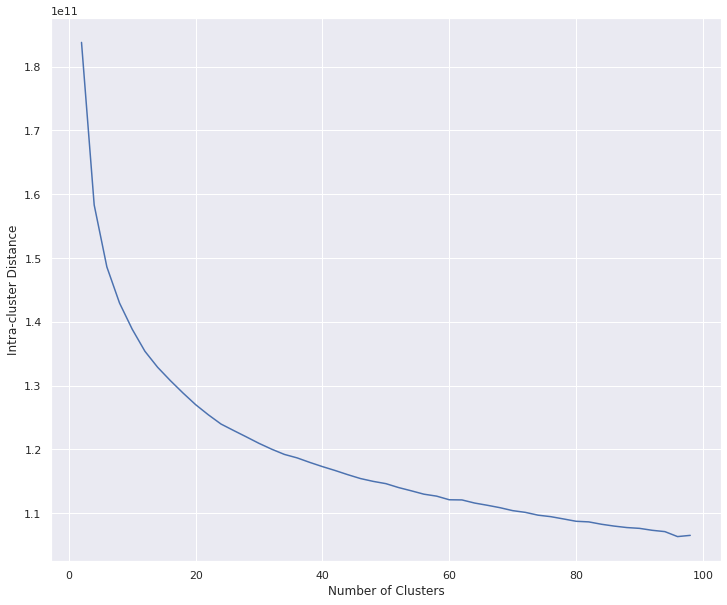

In [13]:
plt.plot(n_cluster_lst, dist_intra_cluster_lst)
plt.ylabel('Intra-cluster Distance')
plt.xlabel('Number of Clusters')
plt.show()

In [14]:
mdl = KMeans(n_clusters=36)
mdl.fit(X_tr)
label_lst = mdl.predict(X_tr)

In [15]:
# Some presentation

n_im = X.shape[0]
index_lst = np.arange(n_im)
np.random.shuffle(index_lst)
selected_im_lst = []

# Get random 9 images from each cluster
cluster2im_lst = [[] for _ in range(9)]
cluster2filled = [False for _ in range(9)]

for index in index_lst:
    label = label_lst[index]
    if label >= 9 or cluster2filled[label]:
        continue
    selected_im_lst.append(X[index])
    cluster2im_lst[label].append(X[index])
    cluster2filled[label] = len(cluster2im_lst[label]) == 9
    if all(cluster2filled):
        break

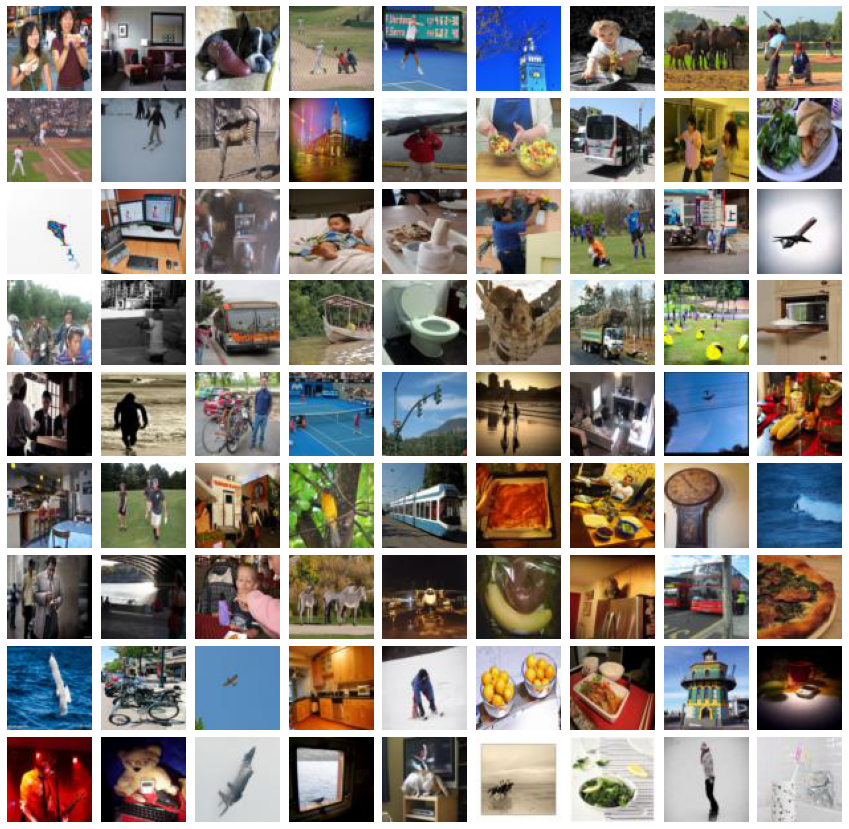

In [16]:
fig = plt.figure(figsize=(15, 15)) # specifying the overall grid size

for i in range(81):
    plt.subplot(9, 9,i+1)
    plt.imshow(selected_im_lst[i].reshape((RESIZED_DIM, RESIZED_DIM, 3)))
    plt.grid(False)
    plt.axis('off')
    plt.subplots_adjust(wspace=0.08, hspace=0.08)
    
plt.show()

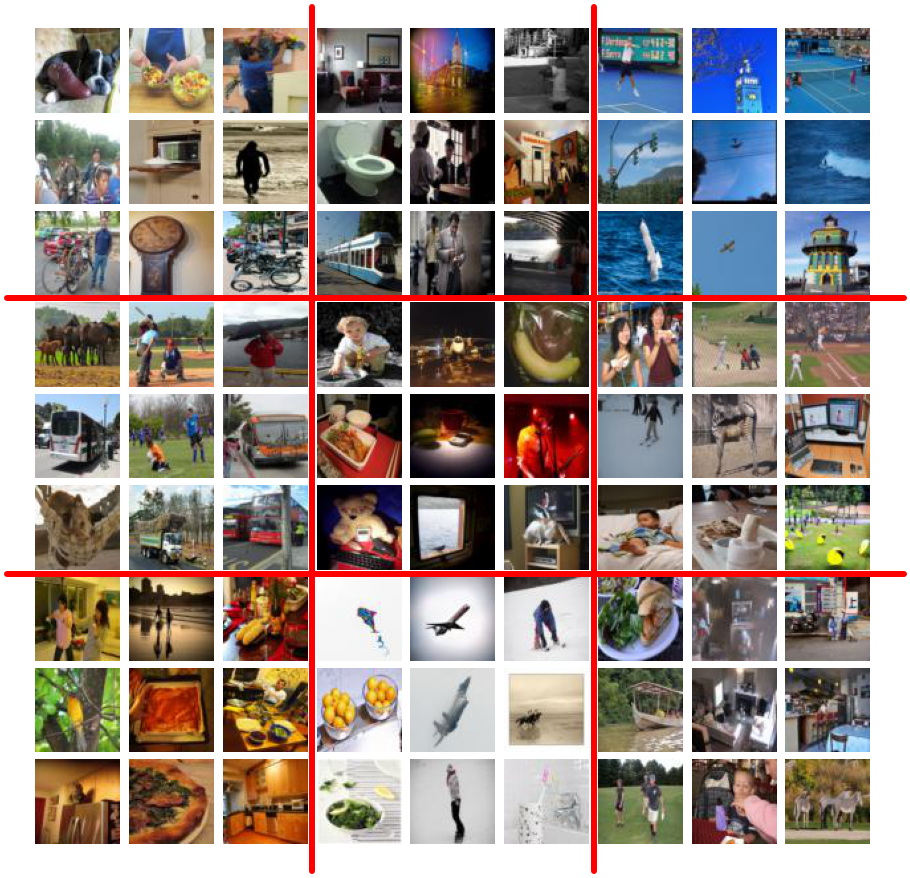

In [17]:
fig = plt.figure(figsize=(15, 15)) # specifying the overall grid size
    
row_pos = 0
col_pos = 0
for label in range(9):
    
    for i, im in enumerate(cluster2im_lst[label]):
        pos = row_pos * 27 + col_pos * 3
        pos += (i // 3) * 9 + (i % 3) + 1
        plt.subplot(9, 9, pos)
        plt.imshow(cluster2im_lst[label][i].reshape((RESIZED_DIM, RESIZED_DIM, 3)))
        plt.grid(False)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.08, hspace=0.08)
    
    col_pos += 1
    if col_pos == 3:
        row_pos += 1
        col_pos = 0
    
for y in [0.375, 0.63]:
    line = plt.Line2D([0.1, 0.93],[y,y], transform=fig.transFigure, color="red", linewidth=6)
    fig.add_artist(line)
for x in [0.382, 0.643]:
    line = plt.Line2D([x,x], [0.1, 0.9], transform=fig.transFigure, color="red", linewidth=6)
    fig.add_artist(line)

plt.show()

In [18]:
def calc_error(X, label_lst, k):
    
    # Calculate cluster centers
    cluster_center_lst = np.empty((k, X.shape[1]))
    
    for i in range(k):
        cluster_center_lst[i] = np.mean(X[label_lst == i])
    
    error = np.linalg.norm(X - cluster_center_lst[label_lst], axis=1).mean()
    return error

In [19]:
# Clustering using PCA
d_pca = 100
k = 20

t_start = time.perf_counter()

# Reduce dimensions
mdl = PCA(n_components=100)
X_tr = mdl.fit_transform(X)

# Cluster
mdl = KMeans(n_clusters=k)
mdl.fit(X_tr)

t_end = time.perf_counter()

pca_elapsed = t_end - t_start
pca_error = calc_error(X, mdl.labels_, k)

print(pca_elapsed, pca_error)

4.902031549001549 6458.103789658617


In [20]:
# Clustering using Random Projection

n_component_lst = [100, 200, 400, 800, 1000, 2000, 4000]
elapsed_lst = []
error_lst = []

for n_component in tqdm(n_component_lst):
    
    t_start = time.perf_counter()
    
    # Reduce dimensions
    mdl = GaussianRandomProjection(n_components=n_component)
    X_tr = mdl.fit_transform(X)
    
    # Cluster
    mdl = KMeans(n_clusters=k)
    mdl.fit(X_tr)
    
    t_end = time.perf_counter()
    elapsed = t_end - t_start
    error = calc_error(X, mdl.labels_, k)
    
    elapsed_lst.append(elapsed)
    error_lst.append(error)

100%|█████████████████████████████████████████████| 7/7 [01:03<00:00,  9.03s/it]


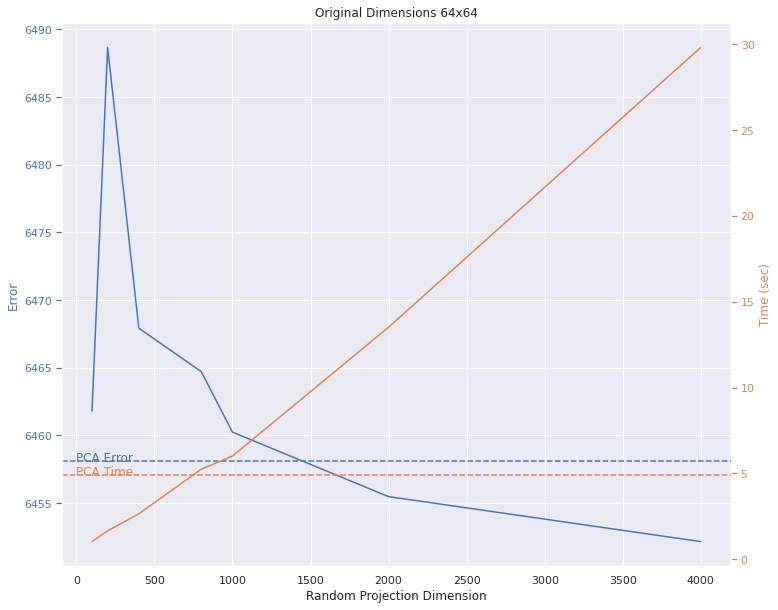

In [21]:
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

# Error plot
ax_left.plot(n_component_lst, error_lst, color=color_cycle[0])
ax_left.set_ylabel('Error')
ax_left.set_xlabel('Random Projection Dimension')
ax_left.yaxis.label.set_color(color_cycle[0])
ax_left.tick_params(axis='y', colors=color_cycle[0])
ax_left.axhline(y=pca_error, color=color_cycle[0], linestyle='--')
ax_left.text(x=0, y=pca_error, s='PCA Error', color=color_cycle[0])

# Time plot
ax_right.plot(n_component_lst, elapsed_lst, color=color_cycle[1])
ax_right.set_ylabel('Time (sec)')
ax_right.grid(False)
ax_right.yaxis.label.set_color(color_cycle[1])
ax_right.tick_params(axis='y', colors=color_cycle[1])
ax_right.axhline(y=pca_elapsed, color=color_cycle[1], linestyle='--')
ax_right.text(x=0, y=pca_elapsed, s='PCA Time', color=color_cycle[1])

plt.title(f'Original Dimensions {RESIZED_DIM}x{RESIZED_DIM}')
plt.show()

In [ ]:
X = np.random.random((5, 4))
print(X)
print(X.var(axis=0))

mdl = RandomColumnSampler(n_component=3)
X_tr = mdl.fit_transform(X)
print(X_tr)

mdl2 = HighVarianceSampler(n_component=3)
X_tr2 = mdl2.fit_transform(X)
print(X_tr2)